Please change the path below to where you want to execute this file and where you store all the versions.

In [1]:
import sys
sys.path.append(r'S:\\')

In [2]:
# For creating plot
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# For terrain shading
import rioxarray as rxr
import xarray as xr
import geopandas as gpd

from shapely.geometry import shape                  # For manipulating spatial information (geometry) under GeoJSON format
from shapely.ops import unary_union                 # For combining all polygons into one
import rasterio

import os
import shutil

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches

import contextily as ctx
import seaborn as sns

import matplotlib.ticker as ticker

### Get main paths

This below cell is for proportion, please change the path according to where you put the version and save file in your local machine.

In [4]:
main_dir = r"S:\\Bathymetry\\versions010\\"
vers = 'neal_combination_001'

save_dir = r"P:\Martin_publication\Bathymetry\All_results"
save_name = 'neal_combination'
save_data = fr"{save_dir}\\water_surface_elevation_{save_name}.jpg"

In [5]:
# Building
building_path = fr"S:\for\GRID\buildings\lds-nz-building-outlines-all-sources-SHP_002.zip"
building_data = gpd.read_file(building_path)

# Terrain
terrain_path = fr"S:\\Bathymetry\\versions010\\{vers}\\0_lidar_data\\shading\\terrain_shading.tiff"
terrain_data = rxr.open_rasterio(fr"{terrain_path}")

### Function

In [6]:
def polygon(axes, x1, y1, x2, y2, c):
    """
    @Definition:
                A function to create polygon
    @Arguments:
                axes (matplotlib axis):
                            Axis of matplotlib subplot
                x1, y1, x2, y2 (float):
                            Coordinates of head (x1, y1) and tail (x2, y2) in matplotlib plot
                c (each color in cmap):
                            Each color in cmap
    @Returns:
                None
    """
    # Make the PDF become a colorbar
    y1=y2=0.03
    
    # Create polygon
    polygon = Polygon(
        [(x1, y1), (x2, y2), (x2, 0), (x1, 0)], color=c
    )
#     print("first: ", x1, y1)
#     print("second: ", x2, y2)

    # Add polygon into patch
    axes.add_patch(polygon)

In [7]:
def rainbow_fill_sns(axes, bin_data, X, Y, ylimit, cmap):
    """
    @Definition:
                A function to create polygon
    @Arguments:
                axes (matplotlib axis):
                            Axis of matplotlib subplot
                bin_data (array):
                            An array of quantiles
                ylimit (float):
                            Value represents the limit of y axis
                X, Y (float):
                            Two list of x and y labels of density plot
                cmap (each color in cmap):
                            Cmap color
    @Returns:
                None
    """
    # Get the size of the data (how many values)
    N = Y.size

    # Create sub-color from main color
    kde_df = pd.DataFrame(data={'kde':X}) # Create dataframe for labels of x axis
    kde_df['color'] = pd.cut(
        kde_df['kde'], bin_data,
        labels=[cmap(x/(bin_data.size-2)) for x in range(bin_data.size-1)],
        ordered=False
    ) # Create groups following range of values from bin_data and label it with sub-color
    kde_df['color'][0] = kde_df['color'][1] # Color the first group otherwise it would be Nan

    # Make the bottom x axis start at 0 of y axis
    axes.set_ylim(top=ylimit, bottom=0)

    # Plot each vertical color
    for n, (x, y) in enumerate(zip(X, Y)):
        # Use polygon
        if n+1 == N: continue
        polygon(axes, x, y, X[n+1], Y[n+1], kde_df['color'][n])

In [8]:
def mark_inset_noconnectedline(parent_axes, inset_axes, zorder=None, **kwargs):
    """
    @Definition:
                A function to create inset plot represent a zooming place in map
    @Arguments:
                parent_axes (matplotlib axis):
                            Axis of matplotlib subplot (the original axis)
                inset_axes (matplotlib axis):
                            Axis of matplotlib inset plot
                zorder (int):
                            Oridinal number of plot layer
                **kwargs:
                            Any other arguments
    @Returns:
                None
    """
    # Get the coordinates of the box based on the parent axes
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)

    # Create the box
    pp = BboxPatch(rect, fill=False, zorder=zorder, **kwargs)

    # Add to parent axes
    parent_axes.add_patch(pp)


In [9]:
def mapping(
    # general arguments
    figsize,
    path_file,
    name_statistics,
    building_data,
    terrain_data,
    
    # Map arguments
    map_range_size,
    cmap_terrain,
    cmap_flood,
    
    # Inset argument
    inset_box_coords,
    
    # Background inset
    clip_max,
    bw_adjust,
    density_rate,
    density_y_limit,
    pdf_xaxis_label,
    x_tick_range_pdf,
    comparison_sign,
    ynumbin, xnumbin,
    rounding,
    rounding_last_x,
    
    # Extract file name
    extract_name,
    
    # Save data
    save_data_func,
    
    # Zoom arguments
    zoomed_coordinates=None,
    zoom=False
):
    
    # Raster
    raster = xr.open_dataset(fr"{path_file}\\{name_statistics}_water.nc")
    
    # Copy for density
    # Copy for density
    z_val = raster.Band1.values.flatten()
    dens = z_val[~np.isnan(z_val)]

    # Set up axes
    fig, parent_axis = plt.subplots(figsize=figsize)

    # (LAYER 0) Plot terrain shade
    terrain_data.plot(ax=parent_axis, cmap=cmap_terrain, add_colorbar=False, zorder=0)

    # (LAYER 2) Plot flood map -----------------------------------------------------------------
    # Plot map
    if name_statistics == 'cell':
        map_range = np.linspace(0, 1, map_range_size)
        map_cell_df = pd.DataFrame(data={'cell':dens}) # Create dataframe with one column containing cell values
        clip_map_cell_df = map_cell_df.query('cell != 100') # Filter values of 100, because this value dominate the
                                                            # data, which will makes quantile full of duplicates
        map_cell_quantile = clip_map_cell_df['cell'].quantile(map_range) # Start quantiling
        map_cell_unique = np.unique(map_cell_quantile.to_numpy()) # Remove duplicates
        map_cell_unique99 = np.append(map_cell_unique, [99.5]) # Add one more value represents the range 99.5 - 100
        map_level = map_cell_unique99
    else:
        map_range = np.linspace(0, 1, map_range_size)
        map_range_quantile = np.quantile(dens, map_range)
        map_level = map_range_quantile

    raster.Band1.plot(ax=parent_axis, levels=map_level,
                      cmap=cmap_flood, add_colorbar=False, alpha=0.8,
                      zorder=2)
    # Remove all grids, frames, and whitespaces
    matplotlib.pyplot.axis('off')
    parent_axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # All font sizes
    fsize = 20

    # Add scale bar
    parent_axis.add_artist(ScaleBar(
        1,
        font_properties={'weight': 'bold', 'size': fsize+10},
        pad=0.5,
        length_fraction=0.1,
        box_color=None,
        box_alpha=0,
        color='black',
        scale_formatter=lambda value, unit: f'{value} {unit}',
        location="lower left"
    ))

    # (LAYER 4) Add arrow
    x_arrow, y_arrow, arrow_length = 0.04, 0.06, 0.1
    parent_axis.annotate(
        'N', fontweight='bold', color='black',
        xy=(x_arrow, y_arrow),
        xytext=(x_arrow, y_arrow+arrow_length),
        arrowprops=dict(arrowstyle='<-, head_width=0.8', facecolor='black', edgecolor='black', linewidth=7,
                        mutation_scale=12),
        ha='center', va='center', fontsize=fsize+15,
        xycoords=parent_axis.transAxes, zorder=4
    )

    # Plot inset plots for density --------------------------------------------------------------
    # Create axis for density
    axins = parent_axis.inset_axes(inset_box_coords, zorder=5)

    # Change background color to transparent
    axins.patch.set_alpha(0)

    # Create data for density
    dens_data = np.clip(dens, min(dens), clip_max) * density_rate

    # Create density
    density_plot = sns.kdeplot(
        dens_data,
        bw_method='silverman',
        bw_adjust=bw_adjust,
        linewidth=.01,
        clip=(min(dens_data), max(dens_data)),
        ax=axins
    )

    # Get data from density
    x_dens = density_plot.lines[0].get_data()[0]
    y_dens = density_plot.lines[0].get_data()[1]

    # Create bins for coloring shade below the curve
    if name_statistics == 'cell':
        newcell_value = clip_map_cell_df['cell'].to_numpy() * density_rate # Create new cell data with density rate
        clip_map_cell100 = clip_map_cell_df.assign(cell=newcell_value) # Assign new values back to cell column
        dens_clip_quantile = clip_map_cell100['cell'].quantile(map_range) # Quantile with new data
        dens_clip_unique = np.unique(dens_clip_quantile.to_numpy()) # Choose unique values
        dens_clip_unique100 = np.append(dens_clip_unique, [99.5*density_rate, 100*density_rate]) # Add group of 100
        dens_quantile_unique = dens_clip_unique100

    else:
        dens_df = pd.DataFrame(data={f'{name_statistics}': dens_data})
        dens_quantile = dens_df[f'{name_statistics}'].quantile(map_range)
        dens_quantile_unique = np.unique(dens_quantile.to_numpy())
        # dens_quantile_unique = dens_quantile.to_numpy()

    # Color shaded area below the density curve
    rainbow_fill_sns(axins, dens_quantile_unique,
                     x_dens, y_dens, density_y_limit, cmap_flood)

    # Generate title and labels
#     axins.set_title("Probability density\nfunction", pad=fsize-12, fontsize=fsize+6, fontweight='bold', color='white')
#     axins.set_title(
#         'Proportion of each pixel\nbeing flooded\nacross 50 simulations',
#         pad=1, fontsize=fsize+6, fontweight='bold', color='white'
#     )
    axins.set_title('')
    axins.text(0.5, 0.7, 
               'Proportion of\neach pixel being flooded\nacross 50 simulations',
               fontsize=fsize+6, fontweight='bold', color='white',
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=axins.transAxes
              )
    axins.set_xlabel(pdf_xaxis_label, fontsize=fsize+8, labelpad=fsize-2, color='white')
#     axins.set_ylabel("Probability density", rotation=-270, fontsize=fsize+9, labelpad=fsize-11, color='white')
    axins.set_ylabel('')

    # Set tick values
    axins.locator_params(nbins=xnumbin, axis='x')
    if rounding == 0:
        # Set tick positions first
        x_range = np.arange(x_tick_range_pdf[0], x_tick_range_pdf[1], x_tick_range_pdf[2]) * density_rate
        xlabel_arr = np.array(np.round(x_range[:], rounding), dtype='int')
        axins.set_xticks(xlabel_arr)

        # Set comparison sign
        x_range = np.arange(x_tick_range_pdf[0], x_tick_range_pdf[1], x_tick_range_pdf[2])
        xlabel_arr = np.array(np.round(x_range[:], rounding), dtype='int')
        xlabel_arr_cop = np.array(np.round(x_range[:], rounding).astype('int'), dtype='str')
        xlabel_arr_cop[-1] = '{1}{0}'.format(xlabel_arr[-1], comparison_sign)
    else:
        # Set tick positions first
        x_range = np.arange(x_tick_range_pdf[0], x_tick_range_pdf[1], x_tick_range_pdf[2]) * density_rate
        xlabel_arr = np.array(np.round(x_range[:], rounding), dtype='float')
        axins.set_xticks(xlabel_arr)

        x_range = np.arange(x_tick_range_pdf[0], x_tick_range_pdf[1], x_tick_range_pdf[2])
        xlabel_arr = np.array(np.round(x_range[:], rounding), dtype='float')
        # Set comparison sign
        if rounding_last_x:
            xlabel_arr_cop = np.array(np.round(x_range[:], rounding), dtype='str')
            xlabel_arr_cop[-1] = '{1}{0}'.format(int(xlabel_arr[-1]), comparison_sign)
        else:
            xlabel_arr_cop = np.array(np.round(x_range[:], rounding), dtype='str')
            xlabel_arr_cop[-1] = '{1}{0}'.format(xlabel_arr[-1], comparison_sign)

    # Add back to x axis
    axins.set_xticklabels(xlabel_arr_cop)

    # Design size and style for ticks and labels
    for item in (axins.get_xticklabels() + axins.get_yticklabels()):  # For x, y ticks' labels
        item.set_fontsize(fsize+9)
    axins.tick_params(direction='out', length=fsize-10, pad=fsize-9, colors='white', width=3)
    axins.locator_params(nbins=ynumbin, axis='y')
    
    # Remove grid background lines (including x, y lines)
    axins.spines['top'].set_visible(False)
    axins.spines['right'].set_visible(False)
    axins.spines['bottom'].set_visible(False)
    axins.spines['left'].set_visible(False)

    # Set x axis limit
    axins.set_xlim(left=x_tick_range_pdf[0]*density_rate)
    
    # Remove y axis
    axins.tick_params(left=False, labelleft=False)

    # Zooming -------------------------------------------------------------------------------------
    if zoom:
        # Get axis
        axins_zoom = parent_axis.inset_axes([0.70, 0.57, 0.3, 0.4], zorder=5) # Original [0.70, 0.57, 0.3, 0.4] or [0.68, 0.65, 0.3, 0.4]

        # Plot hillshade
        terrain_data.plot(ax=axins_zoom, cmap=cmap_terrain, add_colorbar=False, zorder=0)

        # Plot flood map for zooming out
        raster.Band1.plot(ax=axins_zoom, levels=map_level, cmap=cmap_flood, add_colorbar=False, alpha=0.7, zorder=1)

        # Set up coordinates to be zoomed in parent axis
        axins_zoom.set_xlim(zoomed_coordinates[0][0], zoomed_coordinates[0][1])
        axins_zoom.set_ylim(zoomed_coordinates[0][2], zoomed_coordinates[0][3])

        # Remove all labels and ticks of zoom axis
        axins_zoom.set_xticks([])
        axins_zoom.set_yticks([])
        axins_zoom.set_xlabel('')
        axins_zoom.set_ylabel('')

        # Remove black edge of plot background
        for spine in axins_zoom.spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(5)

        # Plot zoom
        mark_inset_noconnectedline(
            parent_axis,
            axins_zoom, zorder=4,
            fc="none", ec="blue", linewidth=5
        )

        # Plot building for zooming plot
        building_data.plot(
            ax=axins_zoom, color='w', edgecolor='0.2', alpha=1, zorder=2
        )

        # Plot basemap for zooming out
        ctx.add_basemap(
            ax=axins_zoom, crs=2193,
            source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}',
            alpha=.3,
            zoom=16,
            zorder=0
        )
        
    else:
        pass

    # Plot basemap, building and save plot ---------------------------------------------------------
    # Save basemap
    ctx.add_basemap(
        ax=parent_axis, crs=2193,
        source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}',
        alpha=0.5, zorder=1
    )

    # Plot building
    building_data.plot(
        ax=parent_axis, color='w', edgecolor='0.2', linewidth=0.05, alpha=0.8, zorder=3
    )

    # Show the plot
    matplotlib.pyplot.show()

    # Save fig
    fig.savefig(
        fr"{save_data_func}",
        bbox_inches='tight', dpi=600
    )

### Plotting

Please change the `path_dir` below to where you store the raster file of proportion.

In [10]:
# MEAN

# Figsize
figsize = (25, 16)

# Path file
path_dir = fr"S:\\Bathymetry\\versions010\\{vers}\\5_analysis\\wd\\bathy_raster"

# Extract name
extract_name = 'n'

# Inset arguments
# inset_box_coords = [0.0995, 0.73, 0.24, 0.17]  # x0, y0, width, height - 0.11, 0.73, 0.22, 0.169 and - 0.0995, 0.73, 0.24, 0.17
inset_box_coords = [0.05, 0.8, 0.30, 0.17]


# General arguments
name_statistics = 'cell'

# Map arguments
map_range_size = 200
cmap_terrain = plt.get_cmap('gist_gray')
cmap_flood = plt.get_cmap('gnuplot')

# Inset arguments 
clip_max = 100 # YOU MIGHT WANT TO CHANGE THIS
bw_adjust = 1
density_rate = 1

# Change density and relating variables
density_y_limit = .16 # YOU MIGHT WANT TO CHANGE THIS
pdf_xaxis_label = "Proportion (%)" # YOU MIGHT WANT TO CHANGE THIS
x_tick_range_pdf = [0, 101, 20] # YOU MIGHT WANT TO CHANGE THIS
comparison_sign = r'' # YOU MIGHT WANT TO CHANGE THIS
ynumbin = 4 # YOU MIGHT WANT TO CHANGE THIS
xnumbin = 6
rounding = 0 # YOU MIGHT WANT TO CHANGE THIS
rounding_last_x = False # YOU MIGHT WANT TO CHANGE THIS

# Zoom
# zoomed_coordinates = [1771326, 1771813, 5473072, 5473335]
# zoomed_coordinates = [1770470 - 130, 1771070 + 130, 5472550 - 130 + 50, 5473200 + 130 + 50]
# zoomed_coordinates = [
#     [1770470 - 130, 1771070 + 130, 5472550 - 130 + 50, 5473200 + 130 + 50]
# ]
zoomed_coordinates = [
    [1770950, 1771550, 5472950, 5473600],
    [1771326+300, 1771813+450, 5473072, 5473335]
]
zoom = True

save_data = fr"{save_dir}\\water_depth_{save_name}_proportion_NOpolyline.jpg"

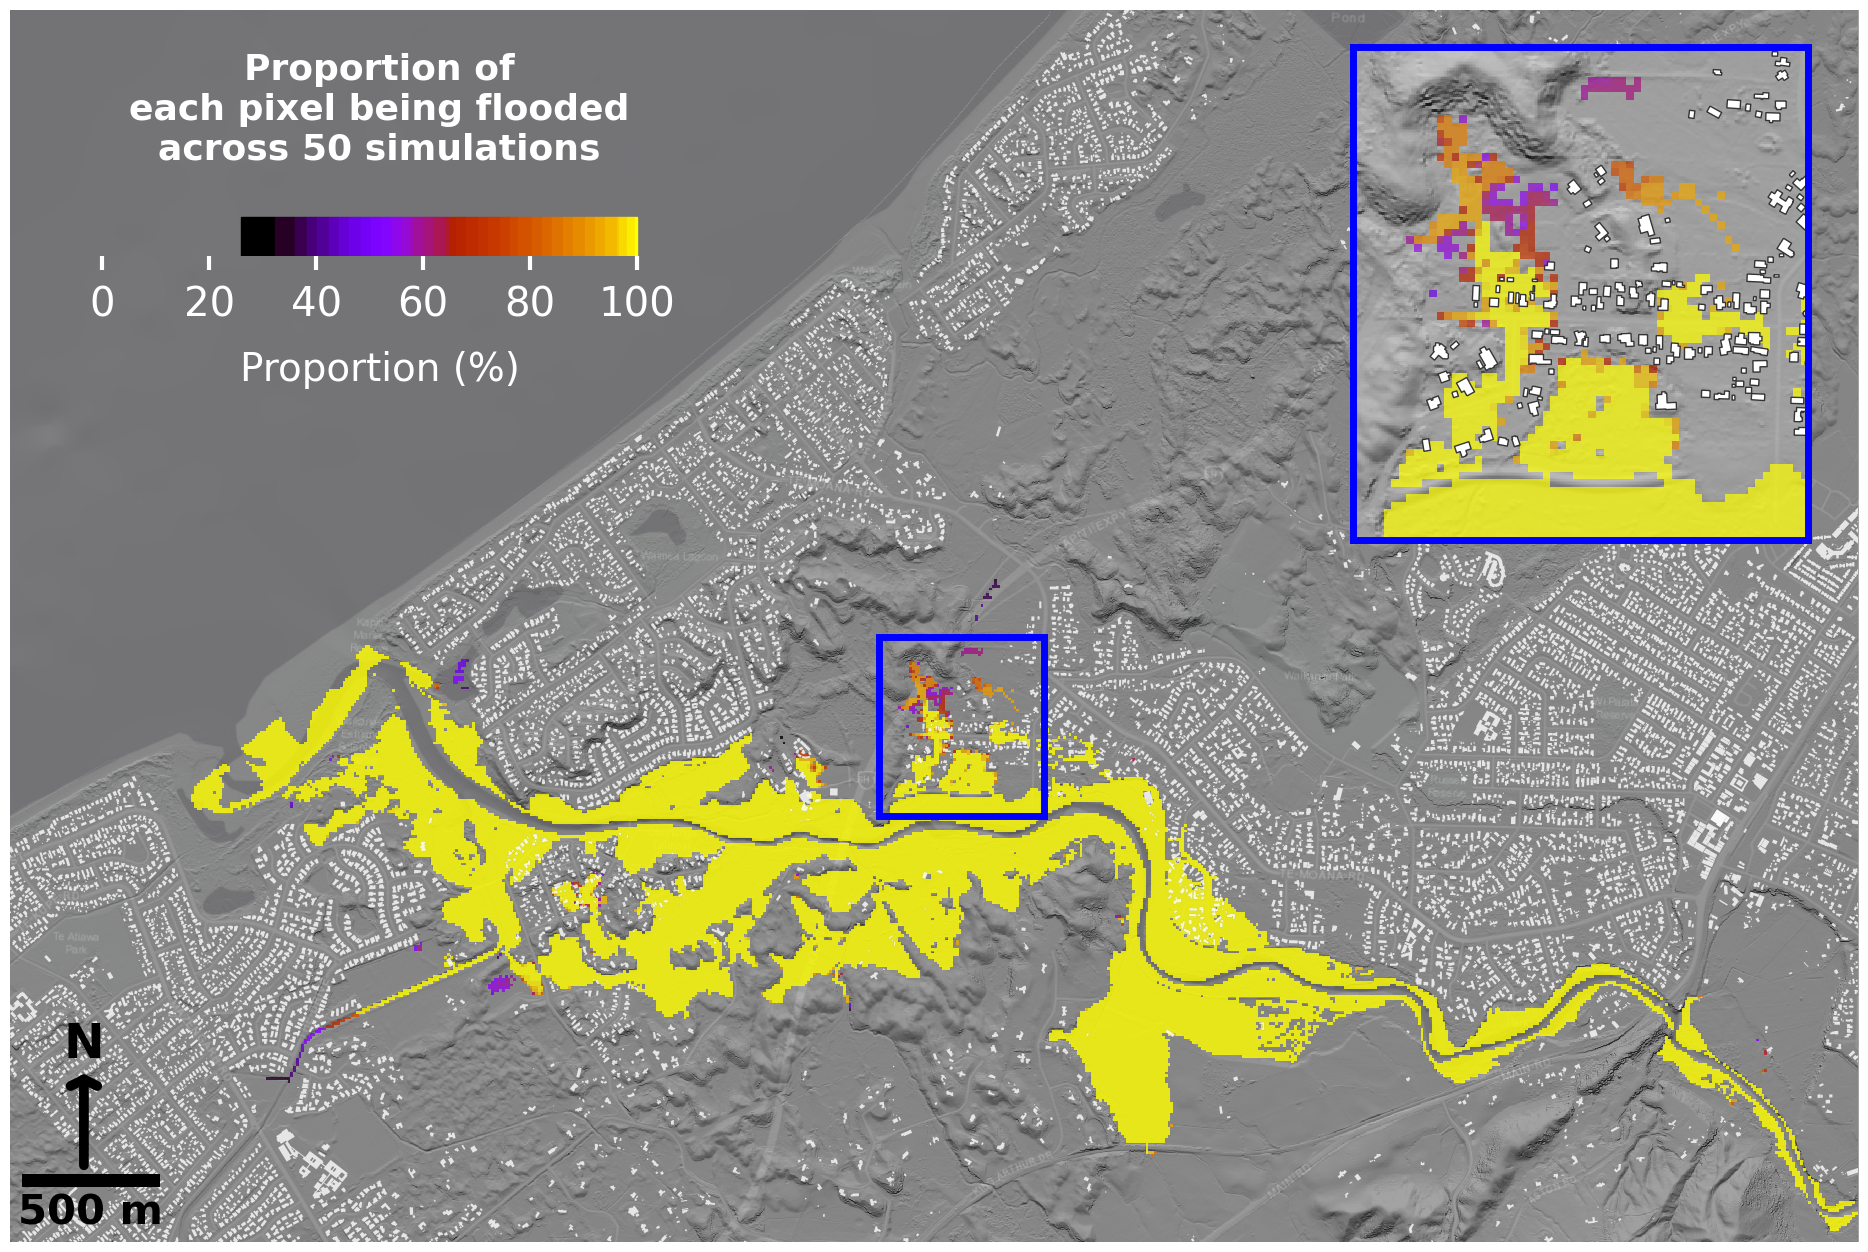

In [11]:
mapping(
    # General arguments
    figsize,
    path_dir,
    name_statistics,
    building_data,
    terrain_data,
    # Map arguments
    map_range_size,
    cmap_terrain,
    cmap_flood,
    # Inset arguments
    inset_box_coords,
    # As we do use background for density plot, because it occupies too much space
    # this line of code is commented
    # background_inset_box_coords,
    clip_max,
    bw_adjust,
    density_rate,
    density_y_limit,
    pdf_xaxis_label,
    x_tick_range_pdf,
    comparison_sign,
    ynumbin, xnumbin,
    rounding,
    rounding_last_x,
    # Extract name
    extract_name,
    save_data,
    # Zoom arguments
    zoomed_coordinates,
    zoom
)